In [1]:
import numpy as np
from datasets import load_dataset
import torch
from transformers import ViTFeatureExtractor
from transformers import TrainingArguments
from transformers import Trainer
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from transformers import ViTForImageClassification, default_data_collator
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, feature_extractor):
        self.img_dir = img_dir
        self.img_labels = []
        self.img_files = []
        self.feature_extractor = feature_extractor
        self.label_mapping = {'REAL': 1, 'FAKE': 0}

        for label_dir in ['REAL', 'FAKE']:
            dir_path = os.path.join(img_dir, label_dir)
            files = os.listdir(dir_path)
            for file in files:
                self.img_files.append(os.path.join(dir_path, file))
                self.img_labels.append(self.label_mapping[label_dir])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels[idx]
        features = self.feature_extractor(images=image, return_tensors="pt")
        # Ensure the output is in a dictionary format
        return {"pixel_values": features['pixel_values'].squeeze(), "labels": torch.tensor(label)}




In [4]:
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)
# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=2
)
model.to(device)

# Initialize the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

# Create the dataset
train_dataset = CustomImageDataset(img_dir='AI_Human_Image_Classification/dataset/train', feature_extractor=feature_extractor)
test_dataset = CustomImageDataset(img_dir='AI_Human_Image_Classification/dataset/test', feature_extractor=feature_extractor)

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


/storage/home/sxk6394/.local/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
device

device(type='cuda')

In [6]:
training_args = TrainingArguments(
    per_device_train_batch_size=4,
    evaluation_strategy="epoch",
    num_train_epochs=4,
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    output_dir="./outputs",
    use_cpu=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
    compute_metrics=None,  # Define your metrics function if needed
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [7]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.140300,0.213086
2,0.116500,0.255878
3,0.106000,0.147361
4,0.028000,0.128957


TrainOutput(global_step=100000, training_loss=0.18765620627851226, metrics={'train_runtime': 6353.0462, 'train_samples_per_second': 62.962, 'train_steps_per_second': 15.74, 'total_flos': 3.09967958458368e+19, 'train_loss': 0.18765620627851226, 'epoch': 4.0})

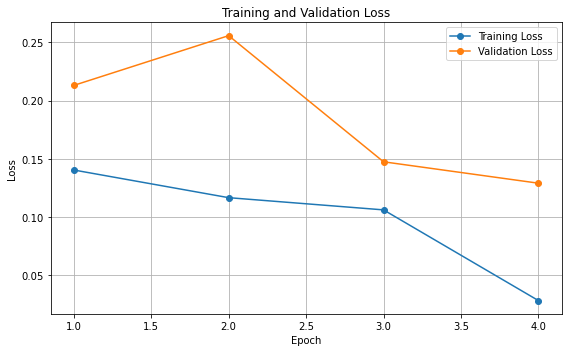

In [1]:
import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

In [18]:
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['pixel_values'].to(device), batch['labels'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits, 1)
            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

In [19]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-i4phxl0i because the default path (/storage/home/sxk6394/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions, true_labels = get_predictions(model, test_loader, device)

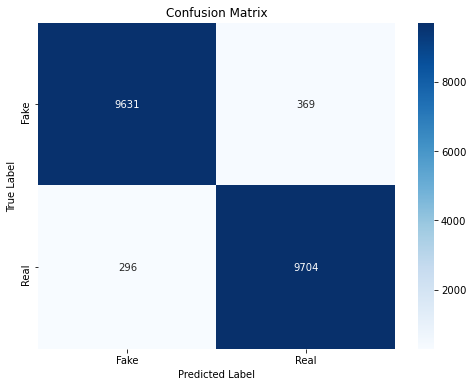

Precision: 0.96
Recall: 0.97
Sensitivity: 0.97
Specificity: 0.96


In [25]:
cm = confusion_matrix(true_labels, predictions)
precision, recall, f_score, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

# Calculate sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display precision, recall, sensitivity, and specificity
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Predicted Label: FAKE


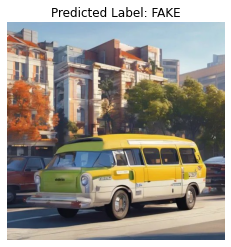

In [43]:
image_path = '2.jpg'
image = Image.open(image_path).convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt")
pixel_values = inputs['pixel_values'].to(device)
model.eval()
with torch.no_grad():
    outputs = model(pixel_values)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

predicted_label = 'REAL' if predicted_class_idx == 1 else 'FAKE'

print(f"Predicted Label: {predicted_label}")

plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

Predicted Label: REAL


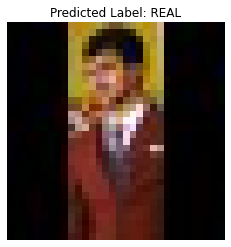

In [46]:
image_path = '4.jpg'
image = Image.open(image_path).convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt")
pixel_values = inputs['pixel_values'].to(device)
model.eval()
with torch.no_grad():
    outputs = model(pixel_values)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

predicted_label = 'REAL' if predicted_class_idx == 1 else 'FAKE'

print(f"Predicted Label: {predicted_label}")

plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

In [35]:
#trainer.save_model("./outputs/final model")